# MLND Project notebook

This notebook is the base version of my project. Seeds, algorithms, epochs, etc. can be modified to validate the results from my project paper. In additiona to using this notebook on my personal computer, I utilized a similar version on AWS instances to get all the results. Total CPU running time exceeds 100+ CPU hours. Moreover, I used a GPU instance for some of the more complex calculations. 

Note that for the `DeepStateEstimateor` as well as for `DeepFactorEstimator`, the current version of `MXNet` as well as `gluonts` is required on the computer or the AWS instance. After installing `MXNet` using pip or conda (not necessary on AWS ML or AWS SageMaker instances), the most recent version of the  `gluonts` library can be installed by directly accessing the github code using 

`!pip install git+https://github.com/awslabs/gluon-ts.git`

The github folder of the gluonts project in conjunction with the GluonTS documentation are very helpful to figuring out how this library works. I used Ubuntu Linux instances.

## Imports

After making sure that `MXNet` is installed on the computer or instance, run the following command to install the most recent version of gluonts. 

For more information follow the installation guide: 

- [Installation guide](http://gluon-ts-staging.s3-accelerate.dualstack.amazonaws.com/PR-271/4/install.html)


The gluonts version that I used for the project:

- `0.3.4.dev68+ga894aee`

### Important Note 

This notebook has to be adjusted in order to replicate the results. To showcase how this works I run it  using `epochs=1`. The project contains information on the number of `epochs`, `num_batches_per_epoch`, `seeds`, etc. to replicate my results.


In [1]:
import gluonts
gluonts.__version__

'0.3.4.dev77+g197866b'

**If gluonts version is <= 0.3.3 uncomment the following line and install gluonts github version directly**

In [2]:
# !pip install git+https://github.com/awslabs/gluon-ts.git

In [3]:
# vis
%matplotlib inline
import matplotlib.pyplot as plt

# standard imports
import numpy as np
import pandas as pd
import random

# printing
from pprint import pprint

# mxnet imports 
import mxnet as mx
from mxnet import gluon

# json library
import json

# gluon imports
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# gluon algorithms
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepar import DeepAREstimator


INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU


## The data

There are various ways to work with the M4 data in python. Initially I downloaded the data from the original website and had to prepare them in order to use them. I later realised that there is a neat library that has a built-in function.

The data can be loaded using the `get_dataset(...)` function. This project coverst the performance of the following data: 

- `m4_hourly`
- `m4_daily`
- `m4_weekly`
- `m4_daily`

Built-in datasets of gluonts are objects that consists of three parts: 

- `dataset.train` - is an iterable collection of data entries used for training. Each entry is one series as a dictionary.
- `dataset.test`- The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length (forecasting horizon in the M4 competition). 
- `dataset.metadata` - contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon (forecast horizon), associated features, etc. 

In [4]:
# load data
dataset = get_dataset("m4_hourly")

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.


Each entry consists of at least a starting timestamp with respective  frequency of the series, and the target time series. In the case of the M4 data the starting time is a generic starting time which is equal for all time series as the starting dates were not known during the competition.  

In [5]:
entry = list(dataset.train)[0]

print("Start:\n", entry["start"])
print("First ten observations:\n", entry["target"][:10])

Start:
 1750-01-01 00:00:00
First ten observations:
 [605. 586. 586. 559. 511. 443. 422. 395. 382. 370.]


In [6]:
entry["target"][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

## Example plot

Series No.: 126


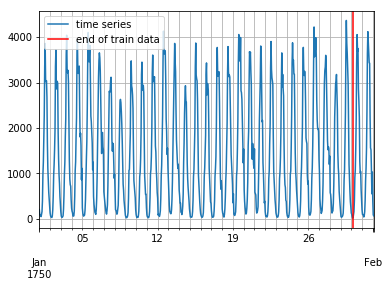

In [7]:
rn = random.randint(0, len(dataset.train))
print("Series No.:", rn)
train_series = to_pandas(list(dataset.train)[rn])
test_series = to_pandas(list(dataset.test)[rn])

test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["time series", "end of train data"], loc="upper left")
plt.show()

## Implementation

### DeepAR 

The **DeepAR** algorithm uses autoregressive features that are used as the inputs to a recurrent neural network. The RNN uses LSTM cells as default but can also changed to GRU cells. In both cases previous time points are taken as input. 

- [`DeepAREestimator`](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html)

Approach: 

1. Define a function that implements DeepAR on a dataset using a specific seed, number of epochs, and batches. The function prints out results for the specified measures of accuracy 
2. Write a loop that iteratively applies this for a range of seeds


In [8]:
# 1. deepar function
def deepar(data="m4_weekly", seed=42, epochs=100, batches=50):
    
    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)
    
    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,      
        num_batches_per_epoch=batches,      
        learning_rate=1e-3,
    )
    
    cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality=[cardinality],
#         context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True   
    )
        
    predictor = estimator.train(dataset.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_eval_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )
    
    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    output["epochs"] = epochs
    output["seed"] = seed
    return(output)


#### Example - Simple Implementation

- Writing a function that applies the algorithm and prints the respective measures.

In [9]:
%%time
res = deepar(data="m4_weekly", seed=42, epochs=1, batches=50)
pprint(res)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 26.00it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[0] Elapsed time 1.925 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.673004
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 7.673003816604615 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:12<00:00, 29.02it/s]

{'MASE': 4.240435,
 'MSIS': 56.05789007,
 'epochs': 1,
 'sMAPE': 0.1118784,
 'seed': 42,
 'wQuantileLoss[0.5]': 0.08156775,
 'wQuantileLoss[0.9]': 0.07146868}
CPU times: user 21.7 s, sys: 457 ms, total: 22.2 s
Wall time: 14.4 s


##### Next: How to apply the function to a range of seeds

The algorithm is not very stable and results depend on the used random numbers. By fixing the seeds and running the algorihtm various times (in particular for seeds 42, 43, 44) the results can be reproduced using the same seeds


In [10]:
%%time
# 2. 
results = []

if __name__ == "__main__":
    for i in range(42, 45):
        print("Seed:", i)
        res = deepar(data="m4_weekly", seed=i, epochs=1, batches=50)
        pprint(res)
        results.append(res)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 49593
100%|██████████| 50/50 [00:01<00:00, 27.02it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[0] Elapsed time 1.852 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.673004
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 7.673003816604615 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:12<00:00, 29.04it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

{'MASE': 4.240435,
 'MSIS': 56.05789007,
 'epochs': 1,
 'sMAPE': 0.1118784,
 'seed': 42,
 'wQuantileLoss[0.5]': 0.08156775,
 'wQuantileLoss[0.9]': 0.07146868}
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 49593
100%|██████████| 50/50 [00:01<00:00, 26.31it/s, avg_epoch_loss=8.13]
INFO:root:Epoch[0] Elapsed time 1.903 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.129509
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 8.129509153366088 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:12<00:00, 29.12it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

{'MASE': 5.01940875,
 'MSIS': 69.61590312,
 'epochs': 1,
 'sMAPE': 0.12262024,
 'seed': 43,
 'wQuantileLoss[0.5]': 0.08975116,
 'wQuantileLoss[0.9]': 0.07865165}
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 49593
100%|██████████| 50/50 [00:01<00:00, 26.34it/s, avg_epoch_loss=8.57]
INFO:root:Epoch[0] Elapsed time 1.900 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.574489
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 8.574489469528197 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:12<00:00, 29.19it/s]

{'MASE': 5.56139708,
 'MSIS': 54.49858637,
 'epochs': 1,
 'sMAPE': 0.12934264,
 'seed': 44,
 'wQuantileLoss[0.5]': 0.09741261,
 'wQuantileLoss[0.9]': 0.07443005}
CPU times: user 1min 4s, sys: 1.43 s, total: 1min 6s
Wall time: 42.8 s


### Deep State Space Models (Rangapuram et al., 2018)

**DeepState** combines state space models (SSM) with a recurrent neural network (RNN). The SSM is applied *locally* to the individual time series that is parametrized using a *global* representation in form of a RNN. The RNN is trained on the entire dataset. 

- [`DeepStateEstimator`](http://gluon-ts.mxnet.io/master/api/gluonts/gluonts.model.deepstate.html#gluonts.model.deepstate.DeepStateEstimator)

Approach: 

1. Define a function that implements DeepState on a dataset using a specific seed, number of epochs, and batches. The function prints out results for the specified measures of accuracy 
2. Write a loop that iteratively applies this for a range of seeds


In [11]:
# 1. DeepState function
def deep_state(seed=42, data="m4_weekly", epochs=25, batches=50):
    dataset = get_dataset(data)

    mx.random.seed(seed)
    np.random.seed(seed)
    
    trainer = Trainer(
        ctx=mx.cpu(0),
#         ctx=mx.gpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )

    cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
    estimator = DeepStateEstimator(
        trainer=trainer,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
#         past_length=48,
        use_feat_static_cat=True,
        cardinality=[cardinality],
    )

    predictor = estimator.train(dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_eval_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )
    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    output["epochs"] = epochs
    output["seed"] = seed

    pprint(output)


In [12]:
%%time
# 2.
results = []

if __name__ == "__main__":
    for i in range(42, 45):
        print("Seed:", i)
        res = deep_state(data="m4_weekly", seed=i, epochs=1, batches=50)
        pprint(res)
        results.append(res)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepStateTrainingNetwork: 50821
100%|██████████| 50/50 [02:04<00:00,  2.50s/it, avg_epoch_loss=0.0381]
INFO:root:Epoch[0] Elapsed time 124.806 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.038143
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 0.03814339142292738 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:51<00:00,  7.01it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

{'MASE': 3.56978893,
 'MSIS': 40.94602258,
 'epochs': 1,
 'sMAPE': 0.08328097,
 'seed': 42,
 'wQuantileLoss[0.5]': 0.06242402,
 'wQuantileLoss[0.9]': 0.03790461}
None
Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 50821
100%|██████████| 50/50 [02:04<00:00,  2.49s/it, avg_epoch_loss=0.0189]
INFO:root:Epoch[0] Elapsed time 124.669 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.018925
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 0.01892461149021983 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:51<00:00,  7.01it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

{'MASE': 3.61996606,
 'MSIS': 40.79863179,
 'epochs': 1,
 'sMAPE': 0.08425901,
 'seed': 43,
 'wQuantileLoss[0.5]': 0.0633005,
 'wQuantileLoss[0.9]': 0.03791309}
None
Seed: 44


INFO:root:Number of parameters in DeepStateTrainingNetwork: 50821
100%|██████████| 50/50 [02:04<00:00,  2.50s/it, avg_epoch_loss=0.0674]
INFO:root:Epoch[0] Elapsed time 124.775 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.067430
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 0.06742982789874077 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:51<00:00,  7.01it/s]

{'MASE': 3.83890088,
 'MSIS': 42.63800372,
 'epochs': 1,
 'sMAPE': 0.08592701,
 'seed': 44,
 'wQuantileLoss[0.5]': 0.06564239,
 'wQuantileLoss[0.9]': 0.04004972}
None
CPU times: user 17min 27s, sys: 14.3 s, total: 17min 41s
Wall time: 8min 48s


### Deep Factor (Wang et al.,  2019)

Hybrid method that uses *local* methods that are specific to each time series in the dataset as well as a *global* representation trained on the entire data. The latter is a RNN to learn universal pattern. The current version uses another RNN as local model -> **DeepFactor-RNN (DF-RNN)**

- [`DeepFactorEstimator`](http://gluon-ts.mxnet.io/master/api/gluonts/gluonts.model.deep_factor.html?highlight=deepfactorestimator#gluonts.model.deep_factor.DeepFactorEstimator)
- [Wang et al. (2019)](https://arxiv.org/abs/1905.12417)

Approach: 

1. Define a function that implements DeepFactor on a dataset using a specific seed, number of epochs, and batches. The function prints out results for the specified measures of accuracy 
2. Write a loop that iteratively applies this for a range of seeds


In [13]:
# 1.
def deepfactor(seed=42, data="m4_daily", epochs=100, batches=50):
    
    mx.random.seed(seed)
    np.random.seed(seed)
    
    dataset = get_dataset(data)
    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )

    cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
    estimator = DeepFactorEstimator(
        trainer=trainer,
        cardinality=[cardinality],
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
#         num_layers_global=2,
#         num_layers_local=2
    )

    predictor = estimator.train(dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_eval_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )
    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    pprint(output)

In [14]:
%%time
if __name__ == "__main__":
    deepfactor(seed=42, data="m4_hourly", epochs=1, batches=50)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.33it/s, avg_epoch_loss=1.54e+9]
INFO:root:Epoch[0] Elapsed time 1.246 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1540446931.550000
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 1540446931.55 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 414/414 [00:03<00:00, 125.27it/s]

{'MASE': 68.95163847,
 'MSIS': 2630.3776541,
 'sMAPE': 1.9000183,
 'wQuantileLoss[0.5]': 0.9998612,
 'wQuantileLoss[0.9]': 1.79947925}
CPU times: user 6.23 s, sys: 104 ms, total: 6.33 s
Wall time: 4.58 s


In [15]:
%%time
results = []

if __name__ == "__main__":
    for i in range(42, 45):
        print("Seed:", i)
        res = deepfactor(data="m4_weekly", seed=i, epochs=1, batches=50)
        pprint(res)
        results.append(res)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepFactorTrainingNetwork: 15386


Seed: 42


100%|██████████| 50/50 [00:00<00:00, 64.06it/s, avg_epoch_loss=5.83e+7]
INFO:root:Epoch[0] Elapsed time 0.782 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=58293269.587692
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 58293269.587692305 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:07<00:00, 51.21it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepFactorTrainingNetwork: 15386


{'MASE': 99.10301818,
 'MSIS': 3963.2956435,
 'sMAPE': 1.9981751,
 'wQuantileLoss[0.5]': 0.99981558,
 'wQuantileLoss[0.9]': 1.79933948}
None
Seed: 43


100%|██████████| 50/50 [00:00<00:00, 64.14it/s, avg_epoch_loss=5.31e+7]
INFO:root:Epoch[0] Elapsed time 0.781 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=53114588.504615
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 53114588.50461538 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:07<00:00, 51.26it/s]
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepFactorTrainingNetwork: 15386


{'MASE': 99.09787939,
 'MSIS': 3963.07335994,
 'sMAPE': 1.99769421,
 'wQuantileLoss[0.5]': 0.99977035,
 'wQuantileLoss[0.9]': 1.79925787}
None
Seed: 44


100%|██████████| 50/50 [00:00<00:00, 65.07it/s, avg_epoch_loss=5.87e+7]
INFO:root:Epoch[0] Elapsed time 0.770 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=58687767.138462
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 58687767.13846154 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 359/359 [00:07<00:00, 50.67it/s]

{'MASE': 99.10291488,
 'MSIS': 3963.33124379,
 'sMAPE': 1.99817288,
 'wQuantileLoss[0.5]': 0.99981501,
 'wQuantileLoss[0.9]': 1.79935713}
None
CPU times: user 26 s, sys: 108 ms, total: 26.1 s
Wall time: 23.5 s


In [16]:
print("Done!")

Done!
